# Array measurements ROBAT 226.238:
- 5 mic array adafruit 5 i2s 
- 96khz 
- 2 meters distance (~ far field = 10𝛌; 𝛌max = fmin; 343/2 = 171 Hz --> 10𝛌 = 1715 Hz; at 1000Hz: 6𝛌 = 6*0.343 = 2.04 m)
- measured clockwise (R: 0-90; L: 270-360)
- array rotated around the central mic kept a 2m from source

**HW settings:**
- AWR 445 vol = -40 db
- fireface analog out 1/2 stereo vol = 0db
- tweeter #1

**NOTE:** some sweeps sometimes sounded cropped or incomplete. 
Measures of 0 deg, 100 to 260 deg have been taken with the same setup but on 2/4/2025

![Measurement setup](PXL_20250327_161533895.jpg)

# Output signal
Out signal used during the recordings: 1-40Khz 5ms sweep.

len =  16384
Chirped 1
Chirped 2
Chirped 3
Chirped 4
Chirped 5


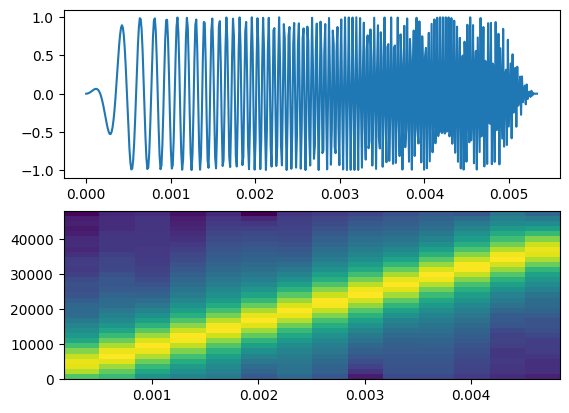

In [2]:
#%%
import time
import sounddevice as sd
import numpy as np
import scipy.signal as signal
from matplotlib import pyplot as plt

def get_soundcard_outstream(device_list):
    for i, each in enumerate(device_list):
        dev_name = each['name']
        asio_in_name = 'MCHStreamer' in dev_name
        if asio_in_name:
            return i

def pow_two_pad_and_window(vec, show = True):
    window = signal.windows.tukey(len(vec), alpha=0.2)
    windowed_vec = vec * window
    padded_windowed_vec = np.pad(windowed_vec, (0, 2**int(np.ceil(np.log2(len(windowed_vec)))) - len(windowed_vec)))
    if show:
        dur = len(padded_windowed_vec) / fs
        t = np.linspace(0, dur, len(windowed_vec))
        plt.figure()
        plt.subplot(2, 1, 1)
        plt.plot(t, windowed_vec)
        plt.subplot(2, 1, 2)
        plt.specgram(windowed_vec, NFFT=64, noverlap=32, Fs=fs)
    return padded_windowed_vec/max(padded_windowed_vec)

def pow_two(vec):
    return np.pad(vec, (0, 2**int(np.ceil(np.log2(len(vec)))) - len(vec)))

if __name__ == "__main__":

    fs = 96e3
    dur = 5e-3
    hi_freq =  1e3
    low_freq = 40e3
    n_sweeps = 5
    
    t_tone = np.linspace(0, dur, int(fs*dur))
    chirp = signal.chirp(t_tone, hi_freq, t_tone[-1], low_freq)
    sig = pow_two_pad_and_window(chirp, show=True)

    silence_dur = 100 # [ms]
    silence_samples = int(silence_dur * fs/1000)
    silence_vec = np.zeros((silence_samples, ))
    full_sig = pow_two(np.concatenate((sig, silence_vec)))
    print('len = ', len(full_sig))
    stereo_sig = np.hstack([full_sig.reshape(-1, 1), full_sig.reshape(-1, 1)])

    output_sig = np.float32(stereo_sig)

    current_frame = 0
    def callback(outdata, frames, time, status):
        global current_frame
        if status:
            print(status)
        chunksize = min(len(output_sig) - current_frame, frames)
        outdata[:chunksize] = output_sig[current_frame:current_frame + chunksize]
        if chunksize < frames:
            outdata[chunksize:] = 0
            raise sd.CallbackAbort()
        current_frame += chunksize

    device = get_soundcard_outstream(sd.query_devices())
# %% 
    try:
        for i in range(n_sweeps): 
            stream = sd.OutputStream(samplerate=fs,
                        blocksize=0,
                        device=device,
                        channels=2,
                        callback=callback,
                        latency='low')
                
            with stream:
                while stream.active:
                    pass

            current_frame = 0
            print('Chirped %d' % (i+1))
            time.sleep(1)

    except KeyboardInterrupt:
        print('Interrupted by user')


# Analysis

1. Angular audiofile import and extraction from multiwav to single channel recordings


In [3]:
# %% Libraries and files
import os
import soundfile as sf

# Load audio files, then plot a 6x6 grid
DIR = "./array_calibration/226_238/2025-03-27/original/"  # Directory containing the audio files
audio_files = os.listdir(DIR)  # List all files in the sweeps directory
audio_files.sort()  # Sort the files in ascending order

# Directory to save the extracted channels
output_dir = "./array_calibration/226_238/2025-03-27/extracted_channels/"
os.makedirs(output_dir, exist_ok=True)  # Create the directory if it doesn't exist

# Path to the multi-channel WAV file
for file in audio_files:
    file_path = os.path.join(DIR, file)

    angle_name = file.split('.')[0]
    print(f"Processing file: {angle_name}")

    # Read the multi-channel WAV file
    audio_data, sample_rate = sf.read(DIR + file)

    # Check the shape of the audio data
    print(f"Audio data shape: {audio_data.shape}")  # (samples, channels)

    # Extract individual channels
    num_channels = audio_data.shape[1]  # Number of channels
    channels = [audio_data[:, i] for i in range(num_channels)]

    # Save each channel as a separate WAV file
    for i, channel_data in enumerate(channels):
        output_file = os.path.join(output_dir, angle_name+f"_{i + 1}.wav")  # Path to the output file
        sf.write(output_file, channel_data, sample_rate)
        print(f"Saved channel {i + 1} to {output_file}")


Processing file: 000
Audio data shape: (894348, 5)
Saved channel 1 to ./array_calibration/226_238/2025-03-27/extracted_channels/000_1.wav
Saved channel 2 to ./array_calibration/226_238/2025-03-27/extracted_channels/000_2.wav
Saved channel 3 to ./array_calibration/226_238/2025-03-27/extracted_channels/000_3.wav
Saved channel 4 to ./array_calibration/226_238/2025-03-27/extracted_channels/000_4.wav
Saved channel 5 to ./array_calibration/226_238/2025-03-27/extracted_channels/000_5.wav
Processing file: 010
Audio data shape: (938608, 5)
Saved channel 1 to ./array_calibration/226_238/2025-03-27/extracted_channels/010_1.wav
Saved channel 2 to ./array_calibration/226_238/2025-03-27/extracted_channels/010_2.wav
Saved channel 3 to ./array_calibration/226_238/2025-03-27/extracted_channels/010_3.wav
Saved channel 4 to ./array_calibration/226_238/2025-03-27/extracted_channels/010_4.wav
Saved channel 5 to ./array_calibration/226_238/2025-03-27/extracted_channels/010_5.wav
Processing file: 020
Audio d

2. Sorting of the angular extracted files into the separate channels

In [4]:
# List all extracted channel files separated by channel number
from natsort import natsorted

# Directory containing the extracted channels
extracted_channels_dir = "./array_calibration/226_238/2025-03-27/extracted_channels/"

# List all extracted channel files
channel_files = os.listdir(extracted_channels_dir)

# Filter out directories, keep only files
channel_files = [f for f in channel_files if os.path.isfile(os.path.join(extracted_channels_dir, f))]

# Sort the files naturally by the last part of their names (e.g., channel number)
sorted_channel_files = natsorted(channel_files, key=lambda x: int(x.split('_')[-1].split('.')[0]))

# Group files by the last part of their name (channel number)
grouped_files = {}

for file in sorted_channel_files:
    # Extract the channel number from the file name (e.g., "350_1.wav" -> "1")
    channel_number = int(file.split('_')[-1].split('.')[0])

    # Group files by channel number
    if channel_number not in grouped_files:
        grouped_files[channel_number] = []
    grouped_files[channel_number].append(file)

for i in range(len(grouped_files)):
    grouped_files[i+1].sort()

# Print grouped files
for channel_number, files in grouped_files.items():
    print(f"Channel {channel_number}:")
    for f in files:
        print(f"  {f}")


Channel 1:
  000_1.wav
  010_1.wav
  020_1.wav
  030_1.wav
  040_1.wav
  050_1.wav
  060_1.wav
  070_1.wav
  080_1.wav
  090_1.wav
  100_1.wav
  110_1.wav
  120_1.wav
  130_1.wav
  140_1.wav
  150_1.wav
  160_1.wav
  170_1.wav
  180_1.wav
  190_1.wav
  200_1.wav
  210_1.wav
  220_1.wav
  230_1.wav
  240_1.wav
  250_1.wav
  260_1.wav
  270_1.wav
  280_1.wav
  290_1.wav
  300_1.wav
  310_1.wav
  320_1.wav
  330_1.wav
  340_1.wav
  350_1.wav
  360_1.wav
Channel 2:
  000_2.wav
  010_2.wav
  020_2.wav
  030_2.wav
  040_2.wav
  050_2.wav
  060_2.wav
  070_2.wav
  080_2.wav
  090_2.wav
  100_2.wav
  110_2.wav
  120_2.wav
  130_2.wav
  140_2.wav
  150_2.wav
  160_2.wav
  170_2.wav
  180_2.wav
  190_2.wav
  200_2.wav
  210_2.wav
  220_2.wav
  230_2.wav
  240_2.wav
  250_2.wav
  260_2.wav
  270_2.wav
  280_2.wav
  290_2.wav
  300_2.wav
  310_2.wav
  320_2.wav
  330_2.wav
  340_2.wav
  350_2.wav
  360_2.wav
Channel 3:
  000_3.wav
  010_3.wav
  020_3.wav
  030_3.wav
  040_3.wav
  050_3.wav
  060_3

3. Matched filtering:
 - Every file is matched with the output
 - First sweep is extracted and displayed
 - Detected sweeps over a threshold value set in the peakfinding to avoid misvalues
 - First sweep is saved to a new directory to be analyzed 
 - avarage RMS of all the sweep in every recording is saved

Processing Channel 1:
Peaks detected in 000_1.wav: 3
RMS value of the first sweep in 000_1.wav: 0.09970
RMS value of sweep at peak 118956 in 000_1.wav: 0.09970
RMS value of sweep at peak 555113 in 000_1.wav: 0.09989
RMS value of sweep at peak 700700 in 000_1.wav: 0.09930
Average RMS value of all sweeps in 000_1.wav: 0.09963
Only 3 sweeps detected in 000_1.wav - Channel 1; expected 5.
 Try adjusting the threshold in detect_peaks.
Peaks detected in 010_1.wav: 5
RMS value of the first sweep in 010_1.wav: 0.11918
RMS value of sweep at peak 132745 in 010_1.wav: 0.11918
RMS value of sweep at peak 278239 in 010_1.wav: 0.11907
RMS value of sweep at peak 423460 in 010_1.wav: 0.11883
RMS value of sweep at peak 568214 in 010_1.wav: 0.11865
RMS value of sweep at peak 713491 in 010_1.wav: 0.11790
Average RMS value of all sweeps in 010_1.wav: 0.11873
Peaks detected in 020_1.wav: 5
RMS value of the first sweep in 020_1.wav: 0.10611
RMS value of sweep at peak 137710 in 020_1.wav: 0.10611
RMS value of 

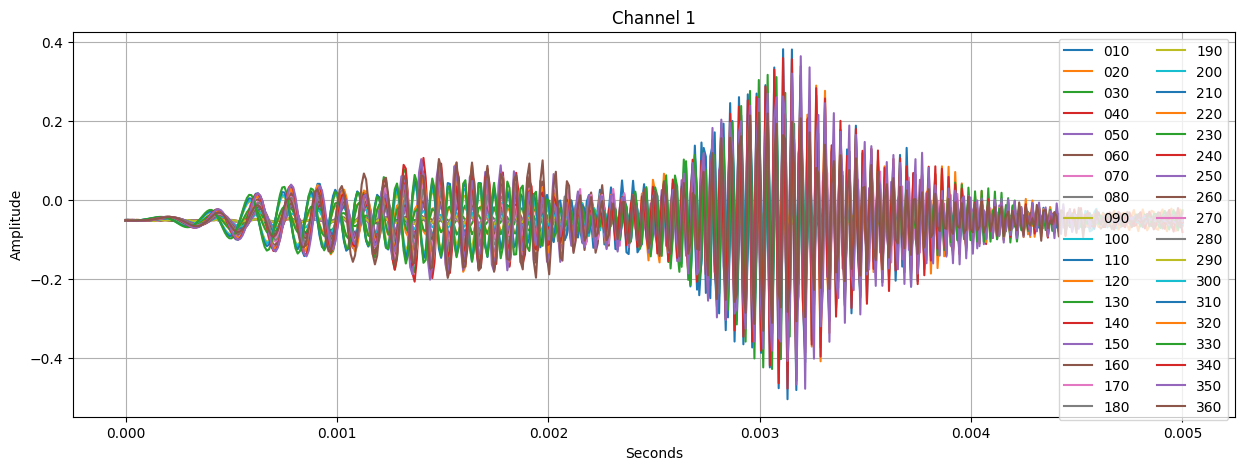

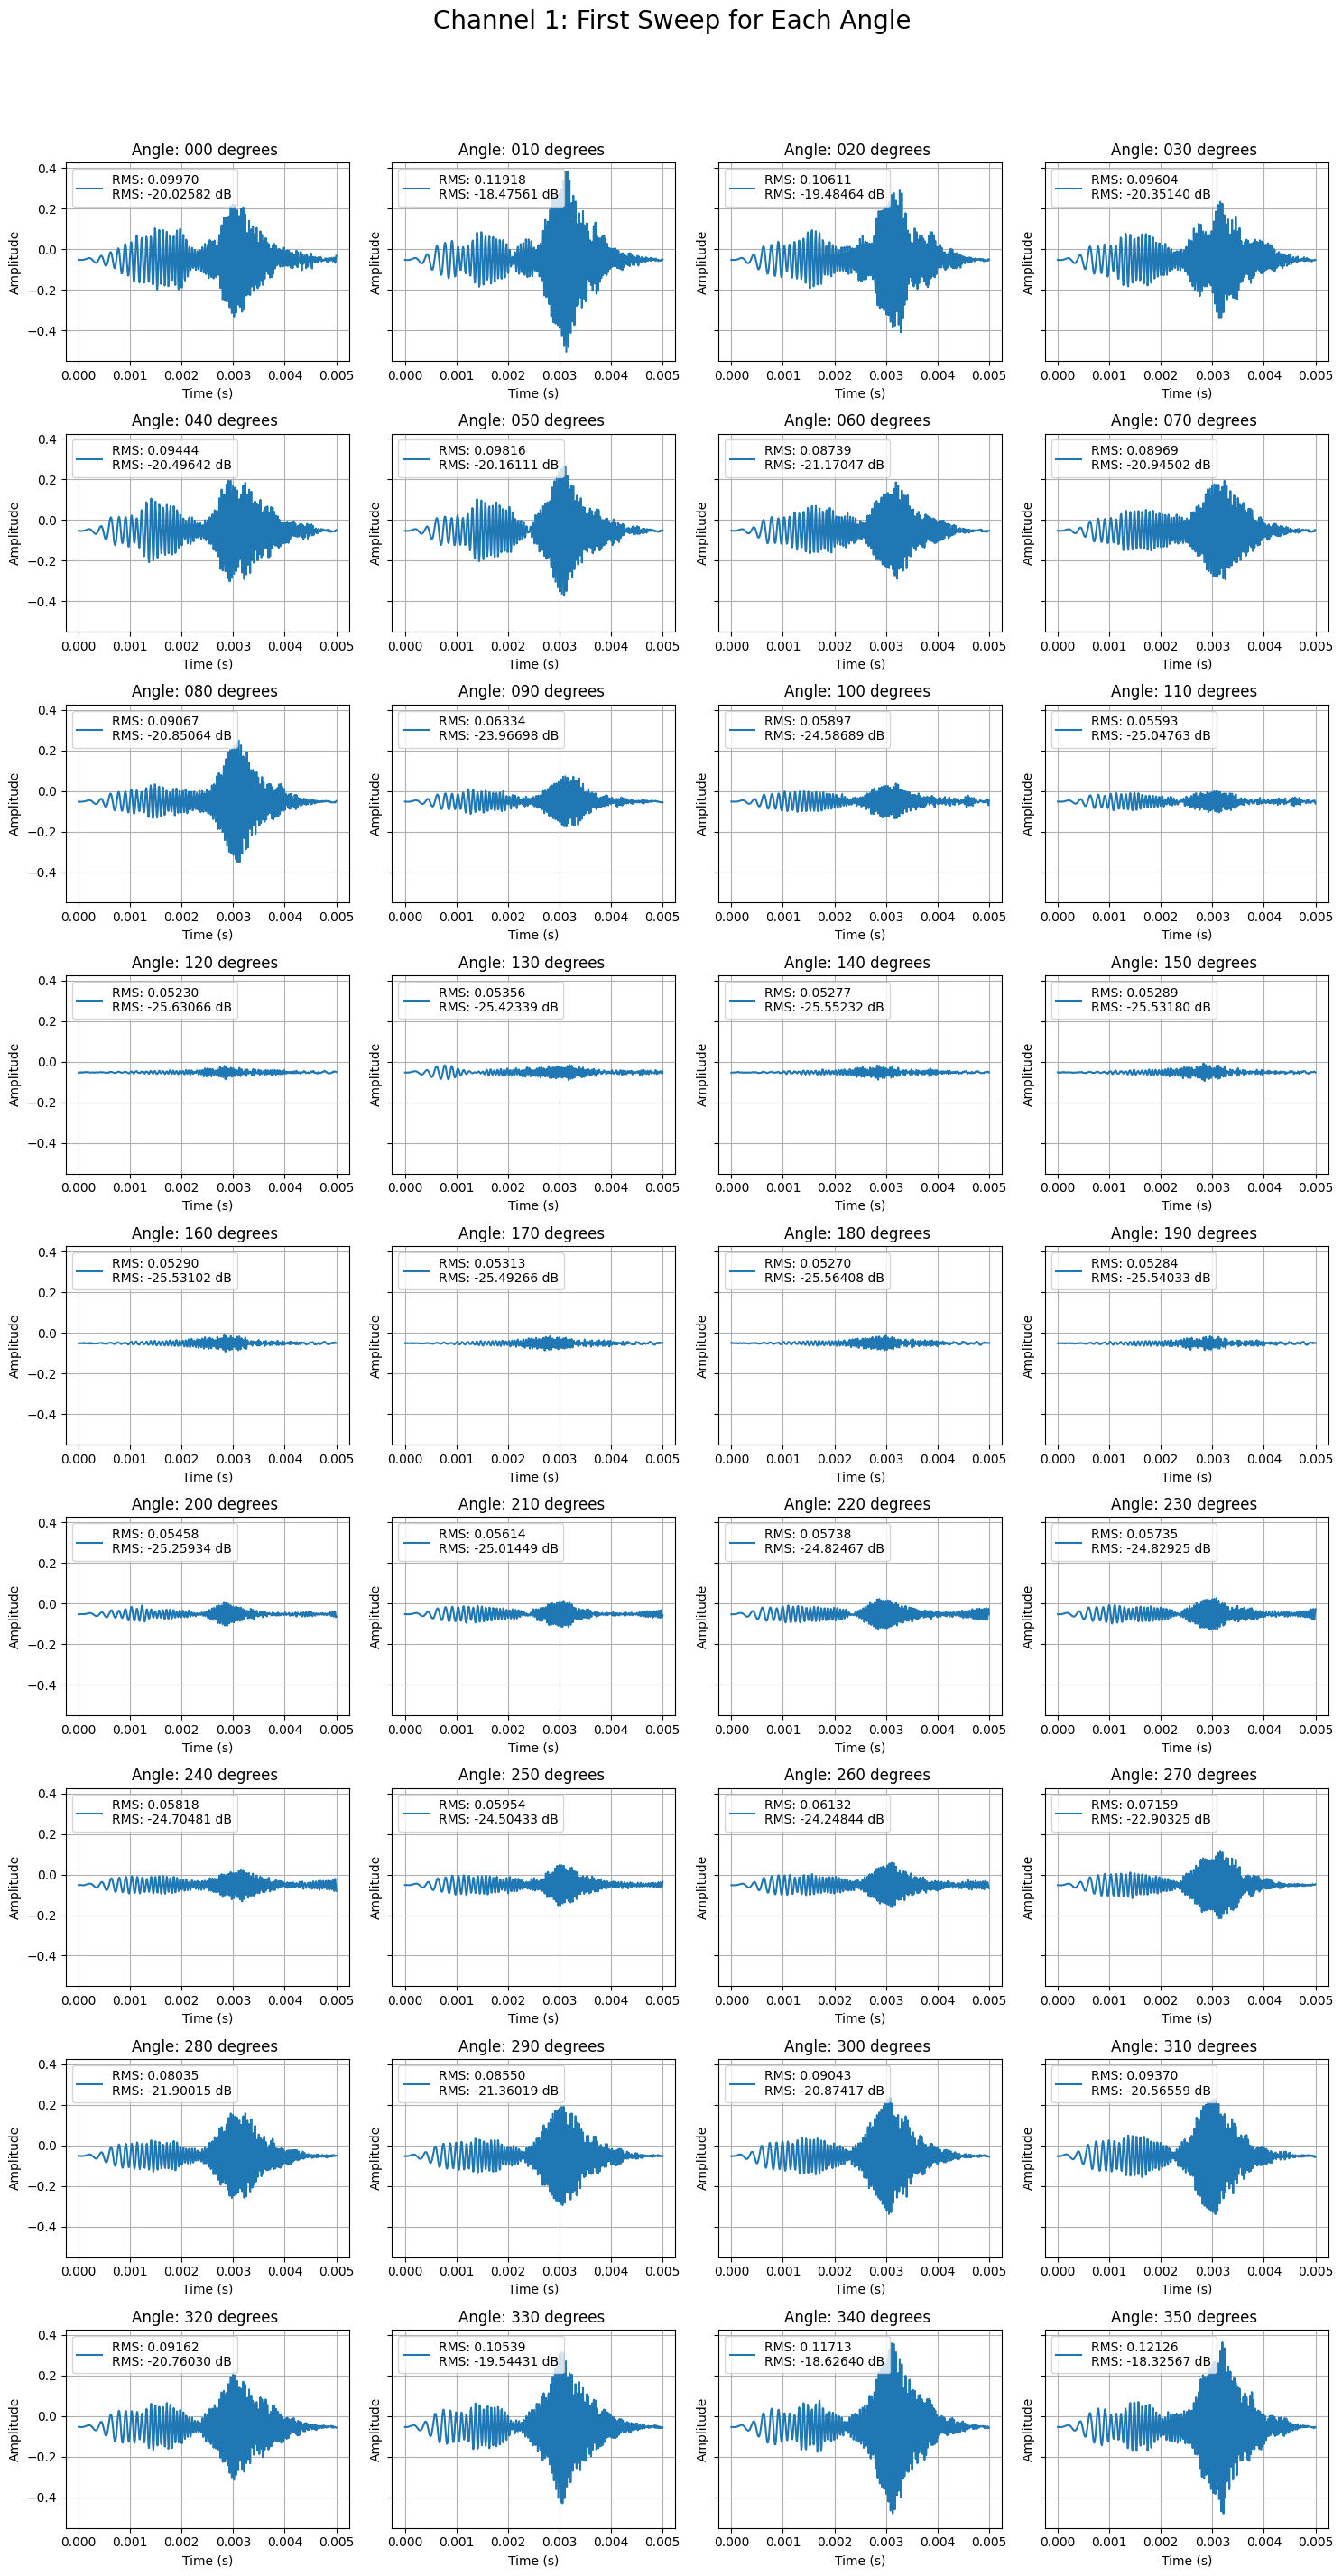

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Processing Channel 2:
Peaks detected in 000_2.wav: 3
RMS value of the first sweep in 000_2.wav: 0.09955
RMS value of sweep at peak 118956 in 000_2.wav: 0.09955
RMS value of sweep at peak 555112 in 000_2.wav: 0.09962
RMS value of sweep at peak 700699 in 000_2.wav: 0.09911
Average RMS value of all sweeps in 000_2.wav: 0.09943
Only 3 sweeps detected in 000_2.wav - Channel 2; expected 5.
 Try adjusting the threshold in detect_peaks.
Peaks detected in 010_2.wav: 5
RMS value of the first sweep in 010_2.wav: 0.11670
RMS value of sweep at peak 132744 in 010_2.wav: 0.11670
RMS value of sweep at peak 278238 in 010_2.wav: 0.11673
RMS value of sweep at peak 423459 in 010_2.wav: 0.11656
RMS value of sweep at peak 568213 in 010_2.wav: 0.11606
RMS value of sweep at peak 713490 in 010_2.wav: 0.11528
Average RMS value of all sweeps in 010_2.wav: 0.11627
Peaks detected in 020_2.wav: 5
RMS value of the first sweep in 020_2.wav: 0.11194
RMS value of sweep at peak 137708 in 020_2.wav: 0.11194
RMS value of 

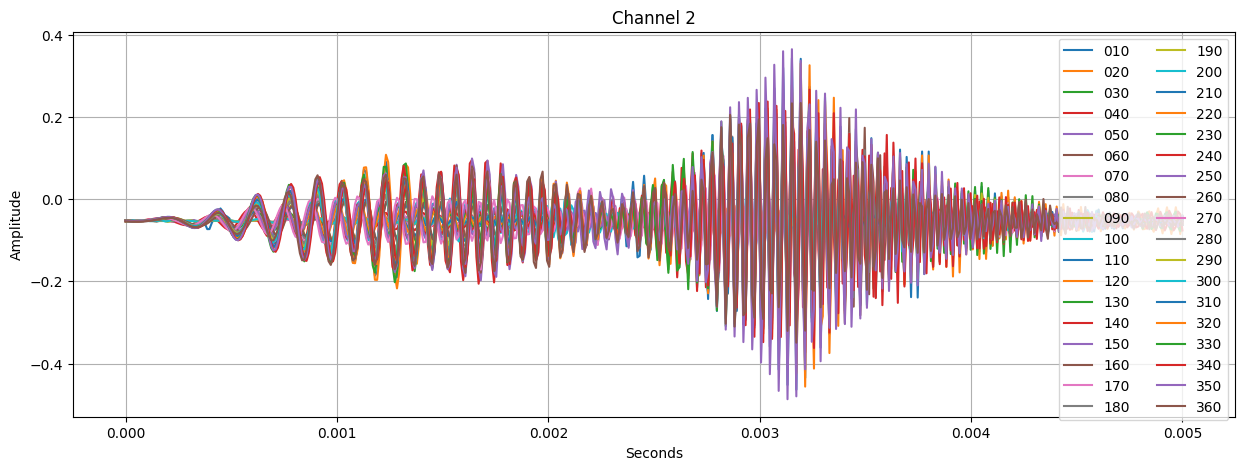

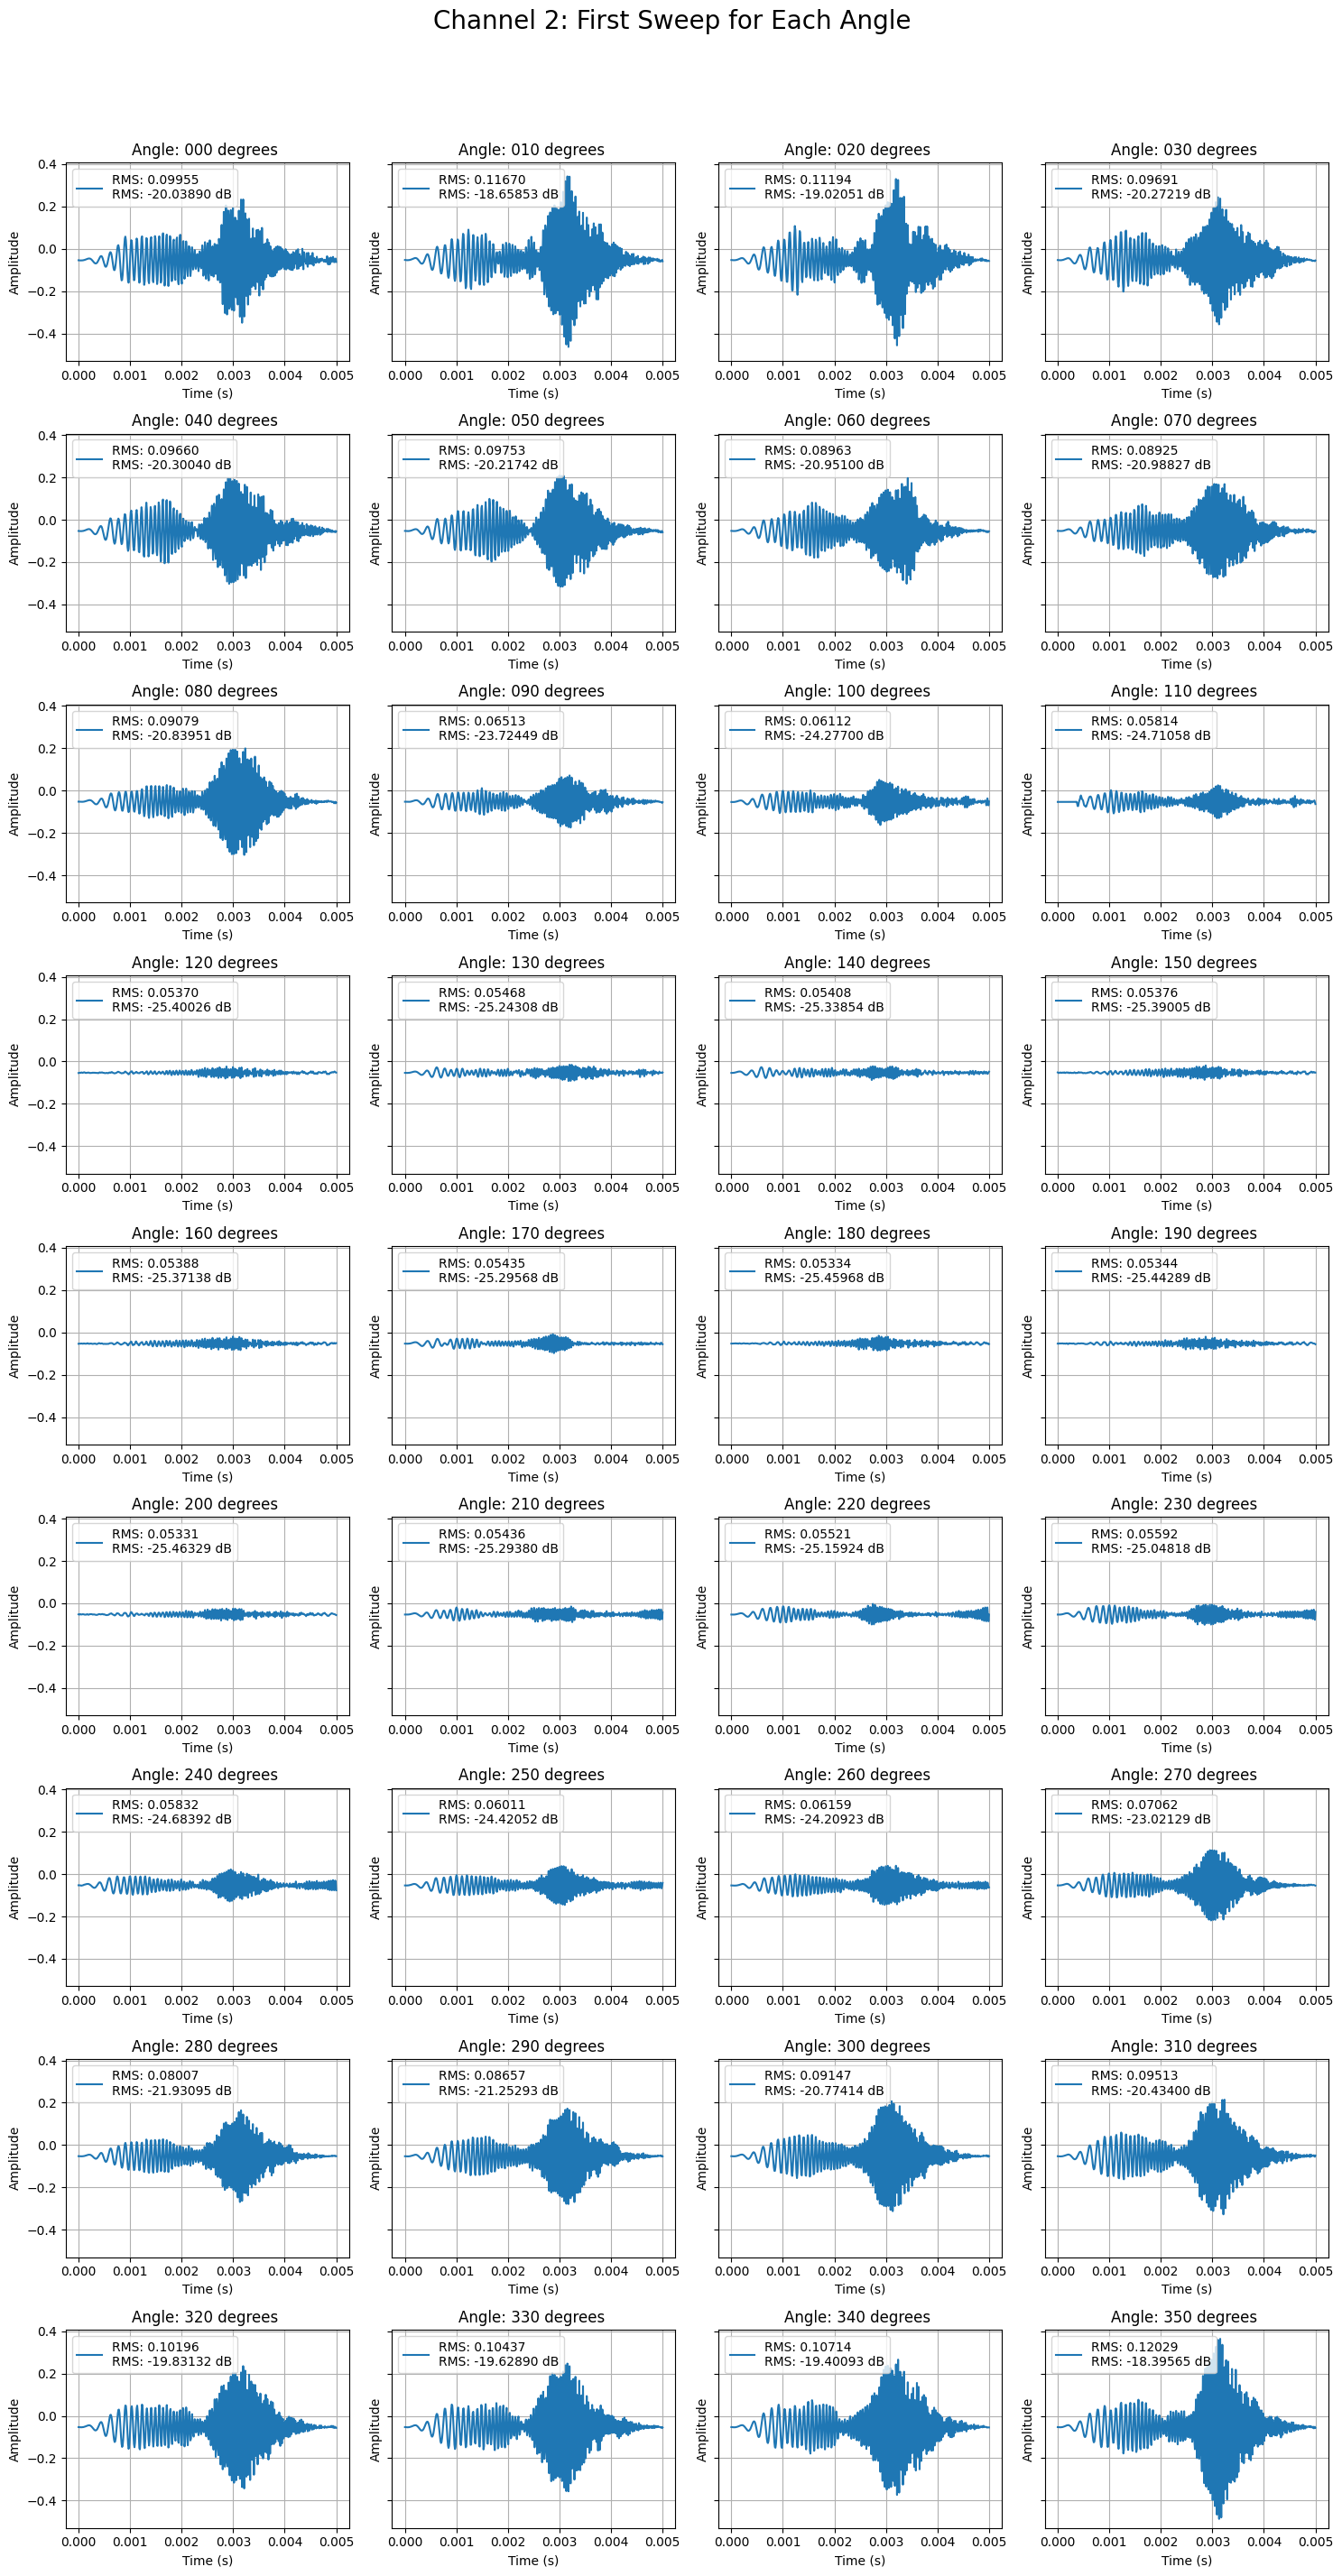

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Processing Channel 3:
Peaks detected in 000_3.wav: 4
RMS value of the first sweep in 000_3.wav: 0.10776
RMS value of sweep at peak 118956 in 000_3.wav: 0.10776
RMS value of sweep at peak 264194 in 000_3.wav: 0.10778
RMS value of sweep at peak 555112 in 000_3.wav: 0.10797
RMS value of sweep at peak 700699 in 000_3.wav: 0.10751
Average RMS value of all sweeps in 000_3.wav: 0.10775
Only 4 sweeps detected in 000_3.wav - Channel 3; expected 5.
 Try adjusting the threshold in detect_peaks.
Peaks detected in 010_3.wav: 5
RMS value of the first sweep in 010_3.wav: 0.13350
RMS value of sweep at peak 132743 in 010_3.wav: 0.13350
RMS value of sweep at peak 278237 in 010_3.wav: 0.13355
RMS value of sweep at peak 423458 in 010_3.wav: 0.13299
RMS value of sweep at peak 568212 in 010_3.wav: 0.13257
RMS value of sweep at peak 713489 in 010_3.wav: 0.13150
Average RMS value of all sweeps in 010_3.wav: 0.13282
Peaks detected in 020_3.wav: 5
RMS value of the first sweep in 020_3.wav: 0.12032
RMS value of 

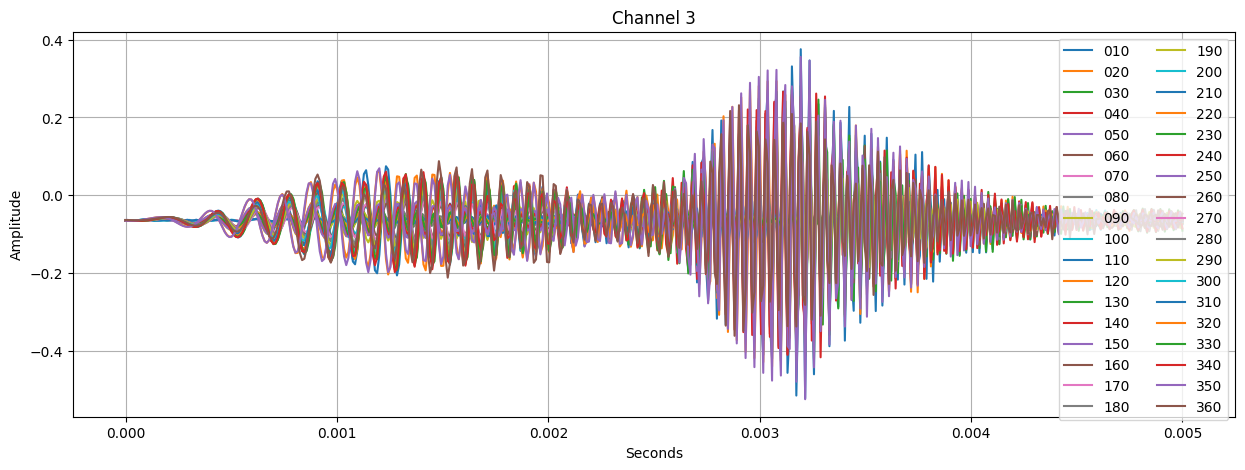

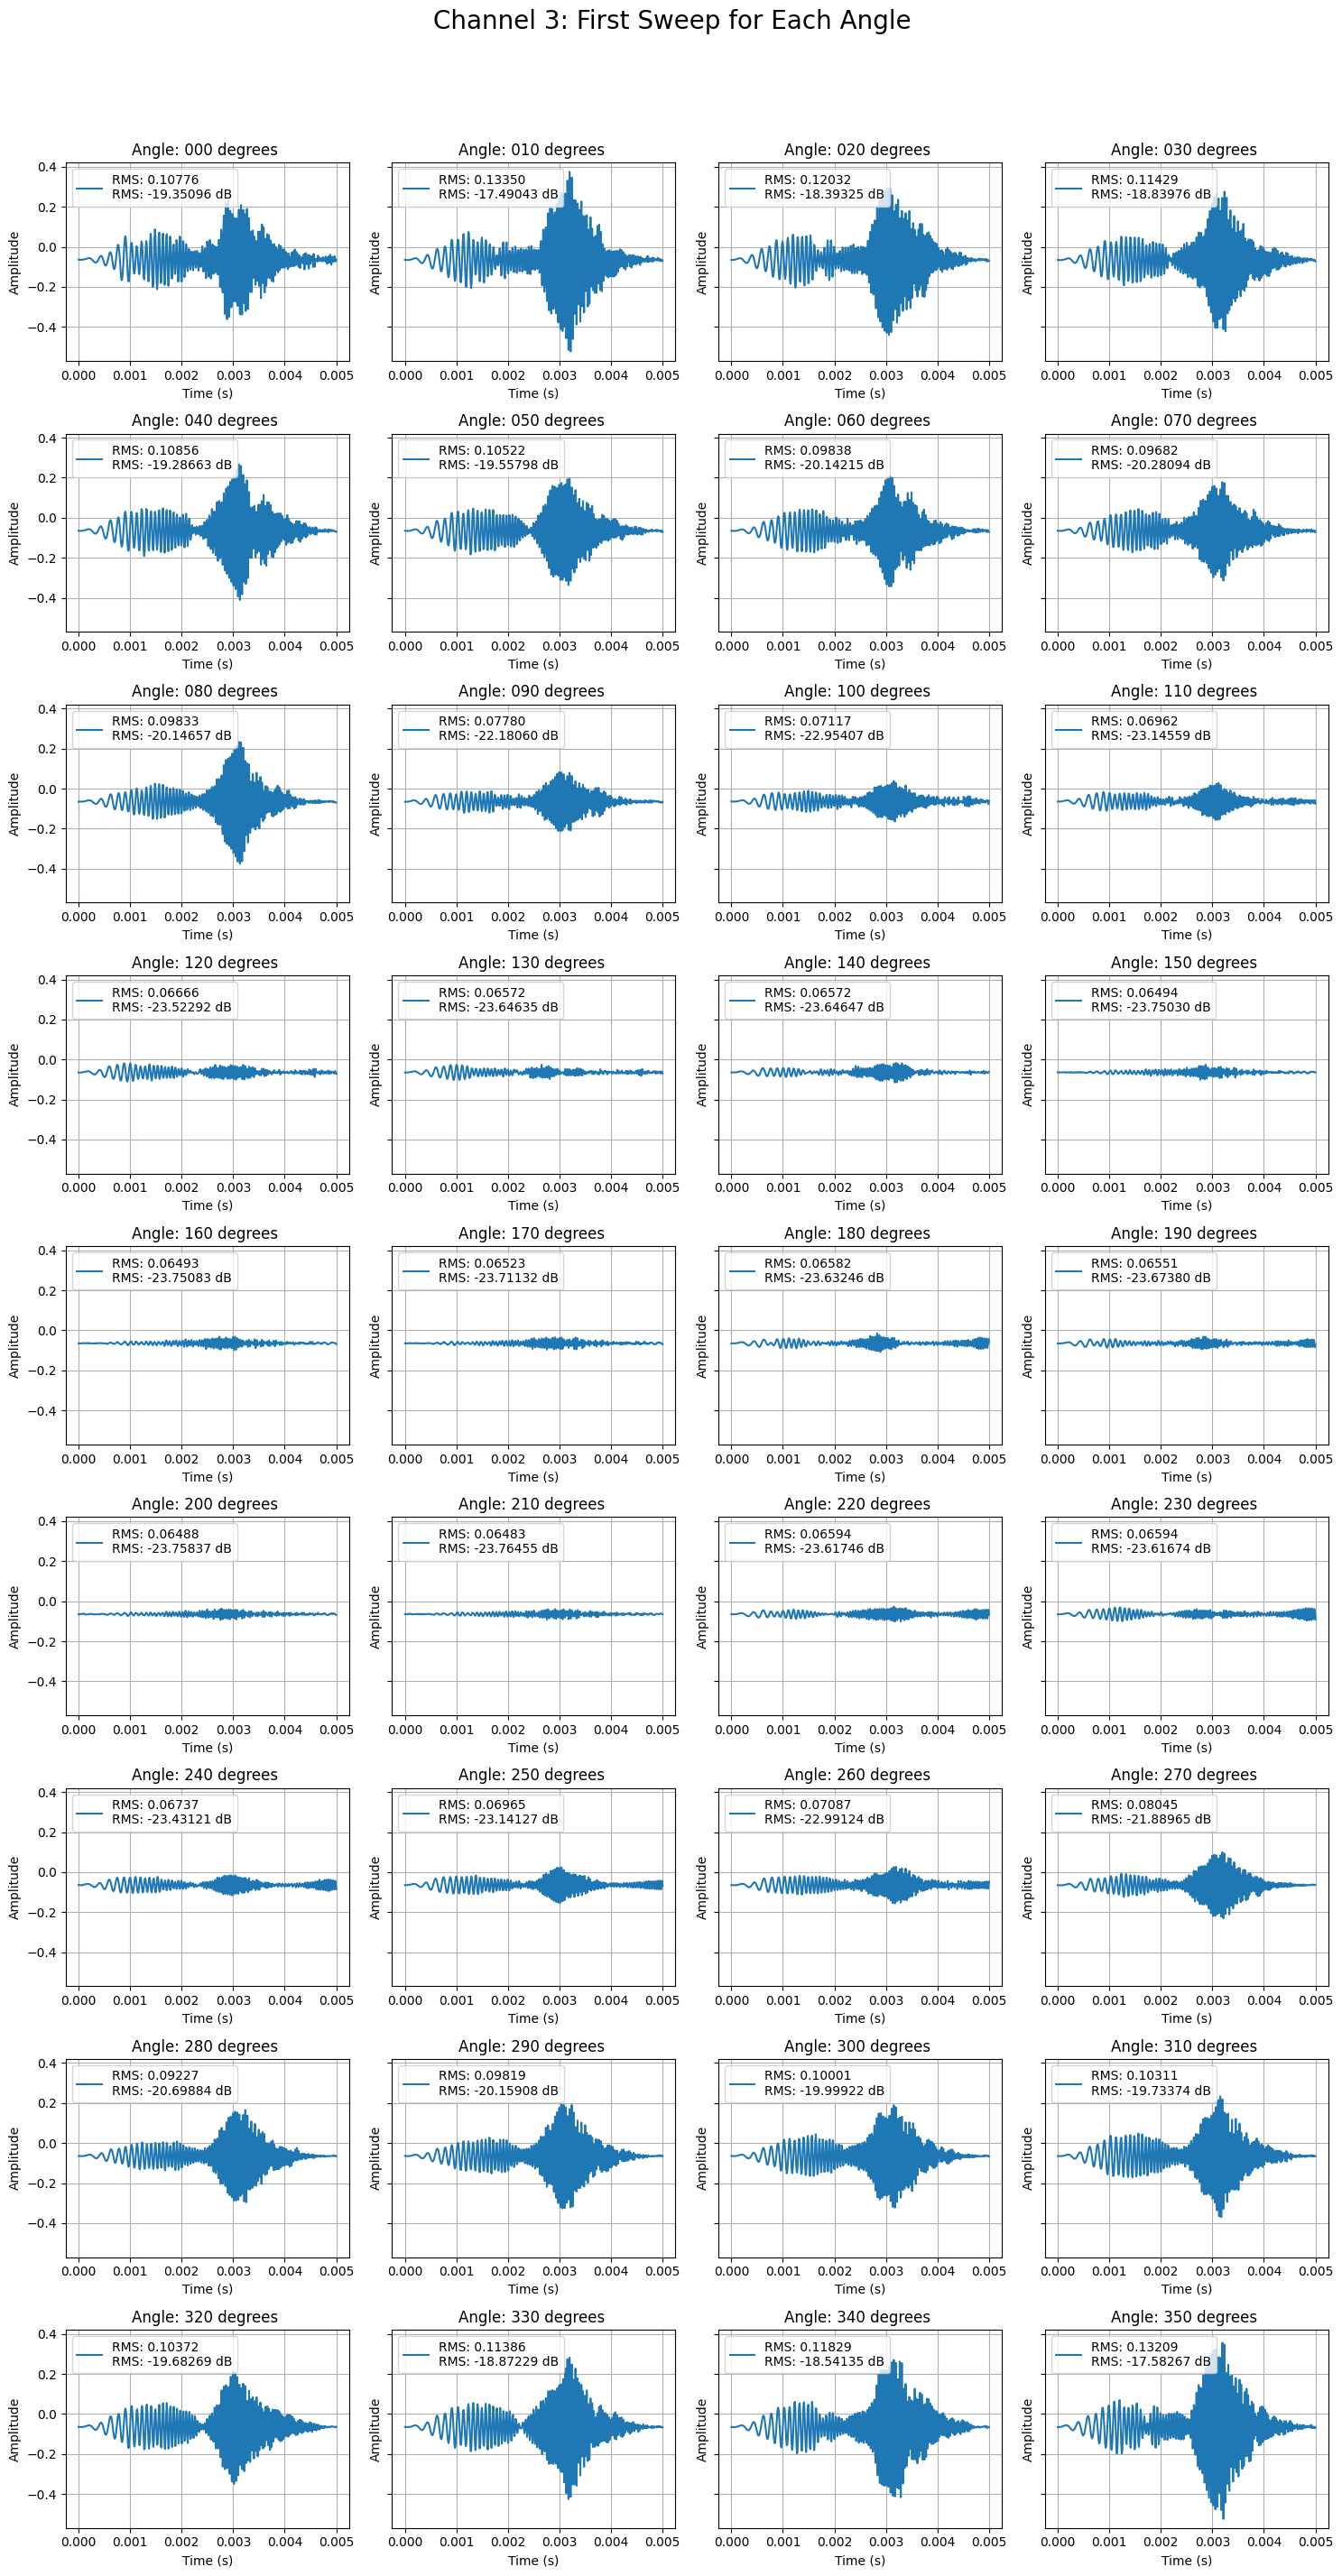

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Processing Channel 4:
Peaks detected in 000_4.wav: 4
RMS value of the first sweep in 000_4.wav: 0.10412
RMS value of sweep at peak 118956 in 000_4.wav: 0.10412
RMS value of sweep at peak 264194 in 000_4.wav: 0.10413
RMS value of sweep at peak 555112 in 000_4.wav: 0.10452
RMS value of sweep at peak 700699 in 000_4.wav: 0.10419
Average RMS value of all sweeps in 000_4.wav: 0.10424
Only 4 sweeps detected in 000_4.wav - Channel 4; expected 5.
 Try adjusting the threshold in detect_peaks.
Peaks detected in 010_4.wav: 5
RMS value of the first sweep in 010_4.wav: 0.13665
RMS value of sweep at peak 132746 in 010_4.wav: 0.13665
RMS value of sweep at peak 278240 in 010_4.wav: 0.13644
RMS value of sweep at peak 423461 in 010_4.wav: 0.13577
RMS value of sweep at peak 568215 in 010_4.wav: 0.13504
RMS value of sweep at peak 713492 in 010_4.wav: 0.13397
Average RMS value of all sweeps in 010_4.wav: 0.13558
Peaks detected in 020_4.wav: 5
RMS value of the first sweep in 020_4.wav: 0.12591
RMS value of 

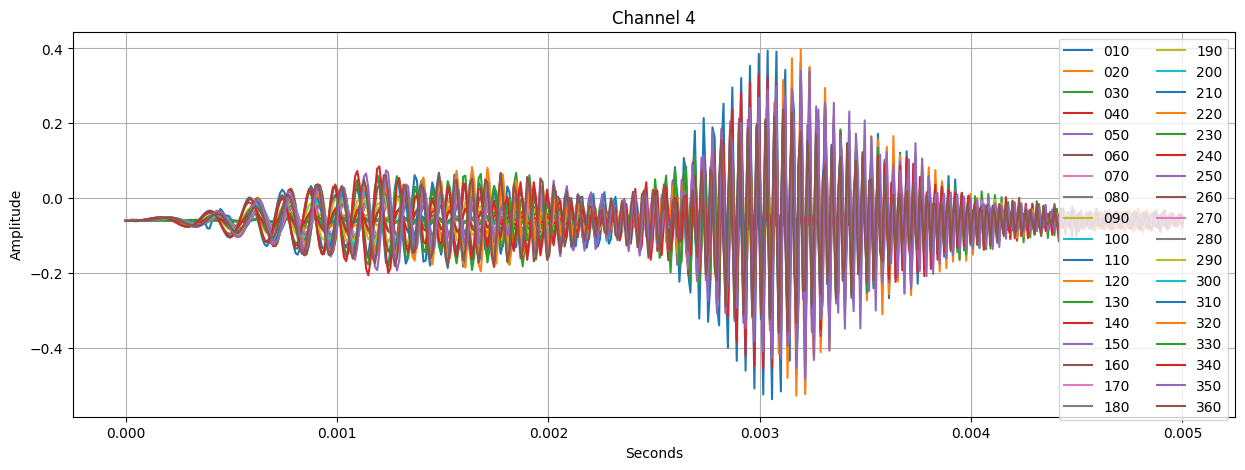

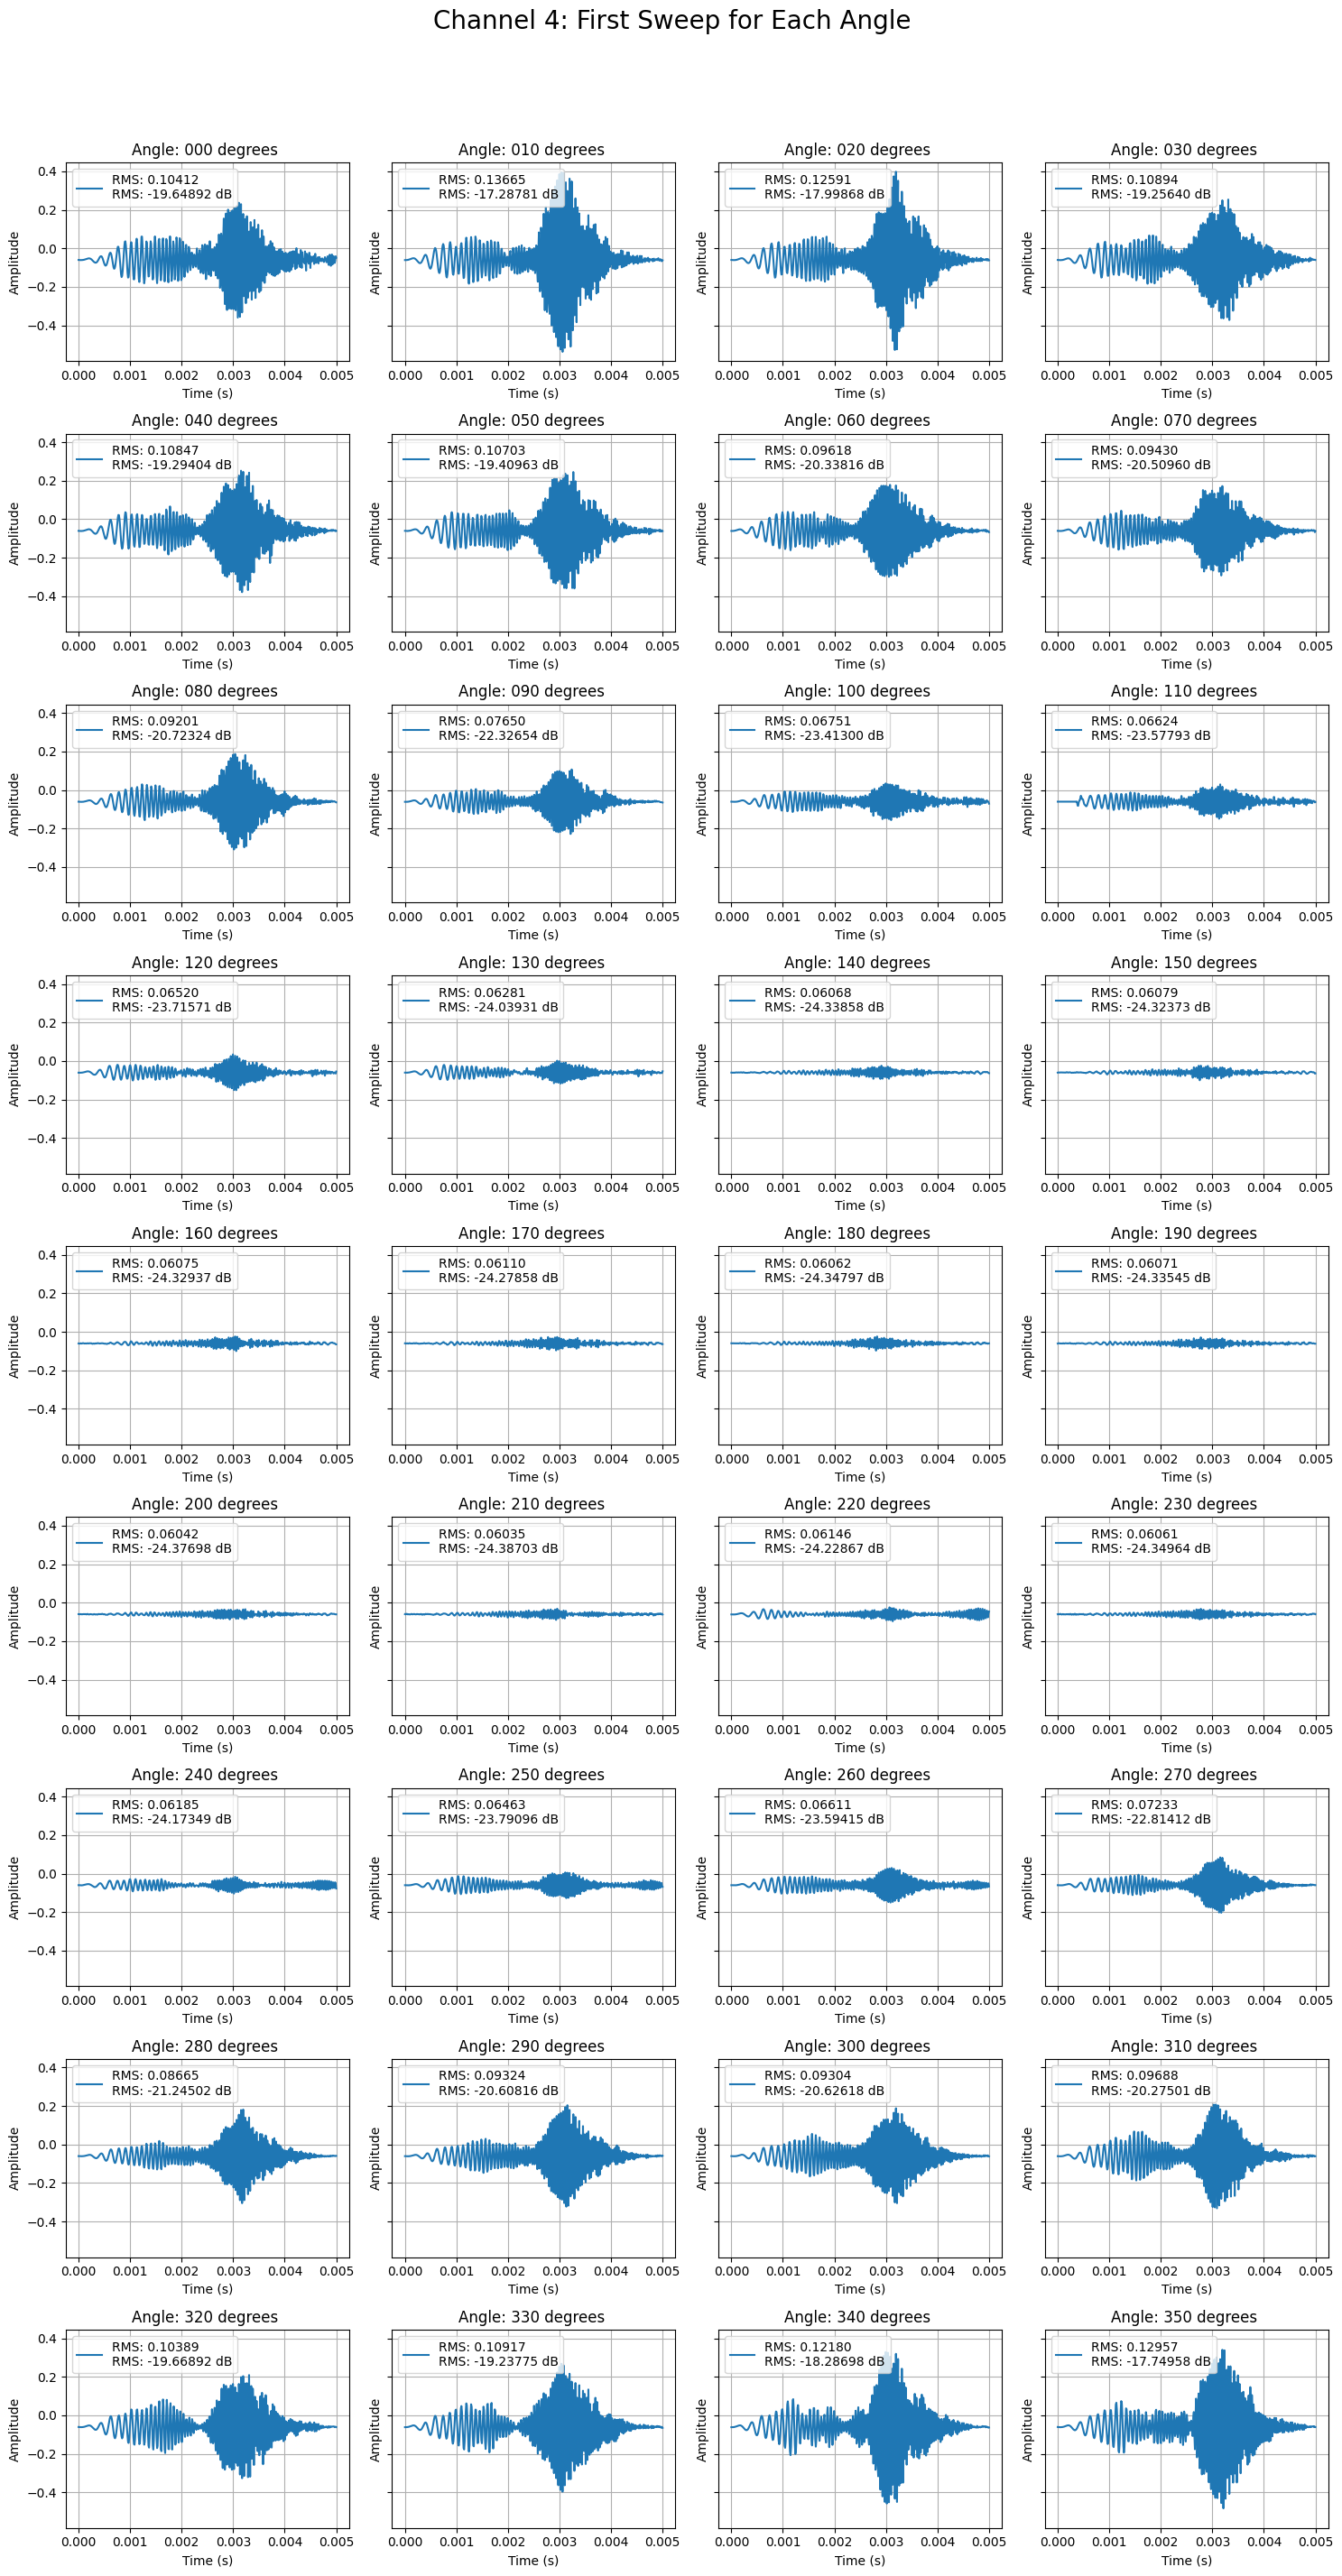

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Processing Channel 5:
Peaks detected in 000_5.wav: 3
RMS value of the first sweep in 000_5.wav: 0.10426
RMS value of sweep at peak 264194 in 000_5.wav: 0.10426
RMS value of sweep at peak 555112 in 000_5.wav: 0.10448
RMS value of sweep at peak 700699 in 000_5.wav: 0.10422
Average RMS value of all sweeps in 000_5.wav: 0.10432
Only 3 sweeps detected in 000_5.wav - Channel 5; expected 5.
 Try adjusting the threshold in detect_peaks.
Peaks detected in 010_5.wav: 5
RMS value of the first sweep in 010_5.wav: 0.13109
RMS value of sweep at peak 132742 in 010_5.wav: 0.13109
RMS value of sweep at peak 278236 in 010_5.wav: 0.13101
RMS value of sweep at peak 423457 in 010_5.wav: 0.13003
RMS value of sweep at peak 568211 in 010_5.wav: 0.12942
RMS value of sweep at peak 713488 in 010_5.wav: 0.12853
Average RMS value of all sweeps in 010_5.wav: 0.13002
Peaks detected in 020_5.wav: 5
RMS value of the first sweep in 020_5.wav: 0.12828
RMS value of sweep at peak 137707 in 020_5.wav: 0.12828
RMS value of 

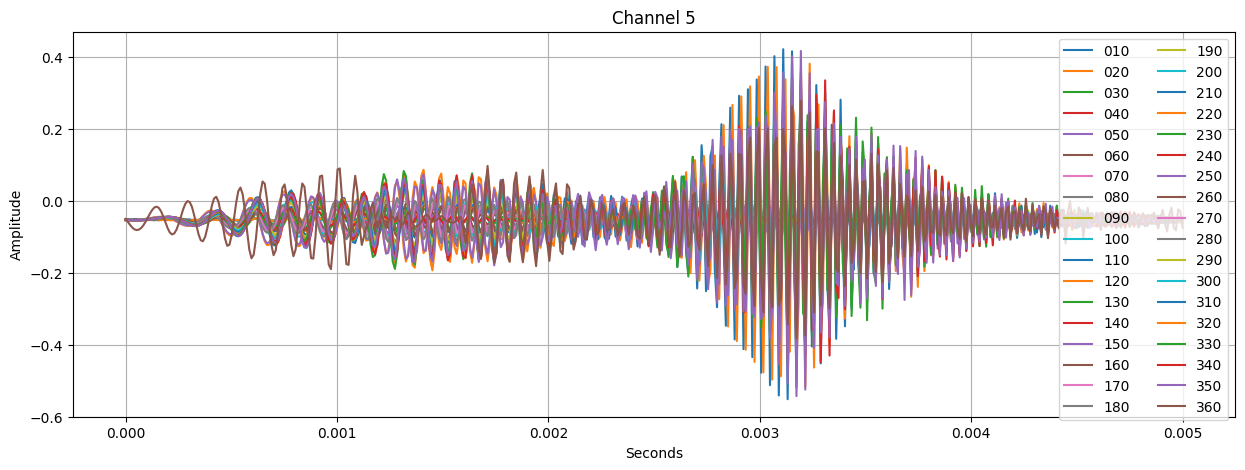

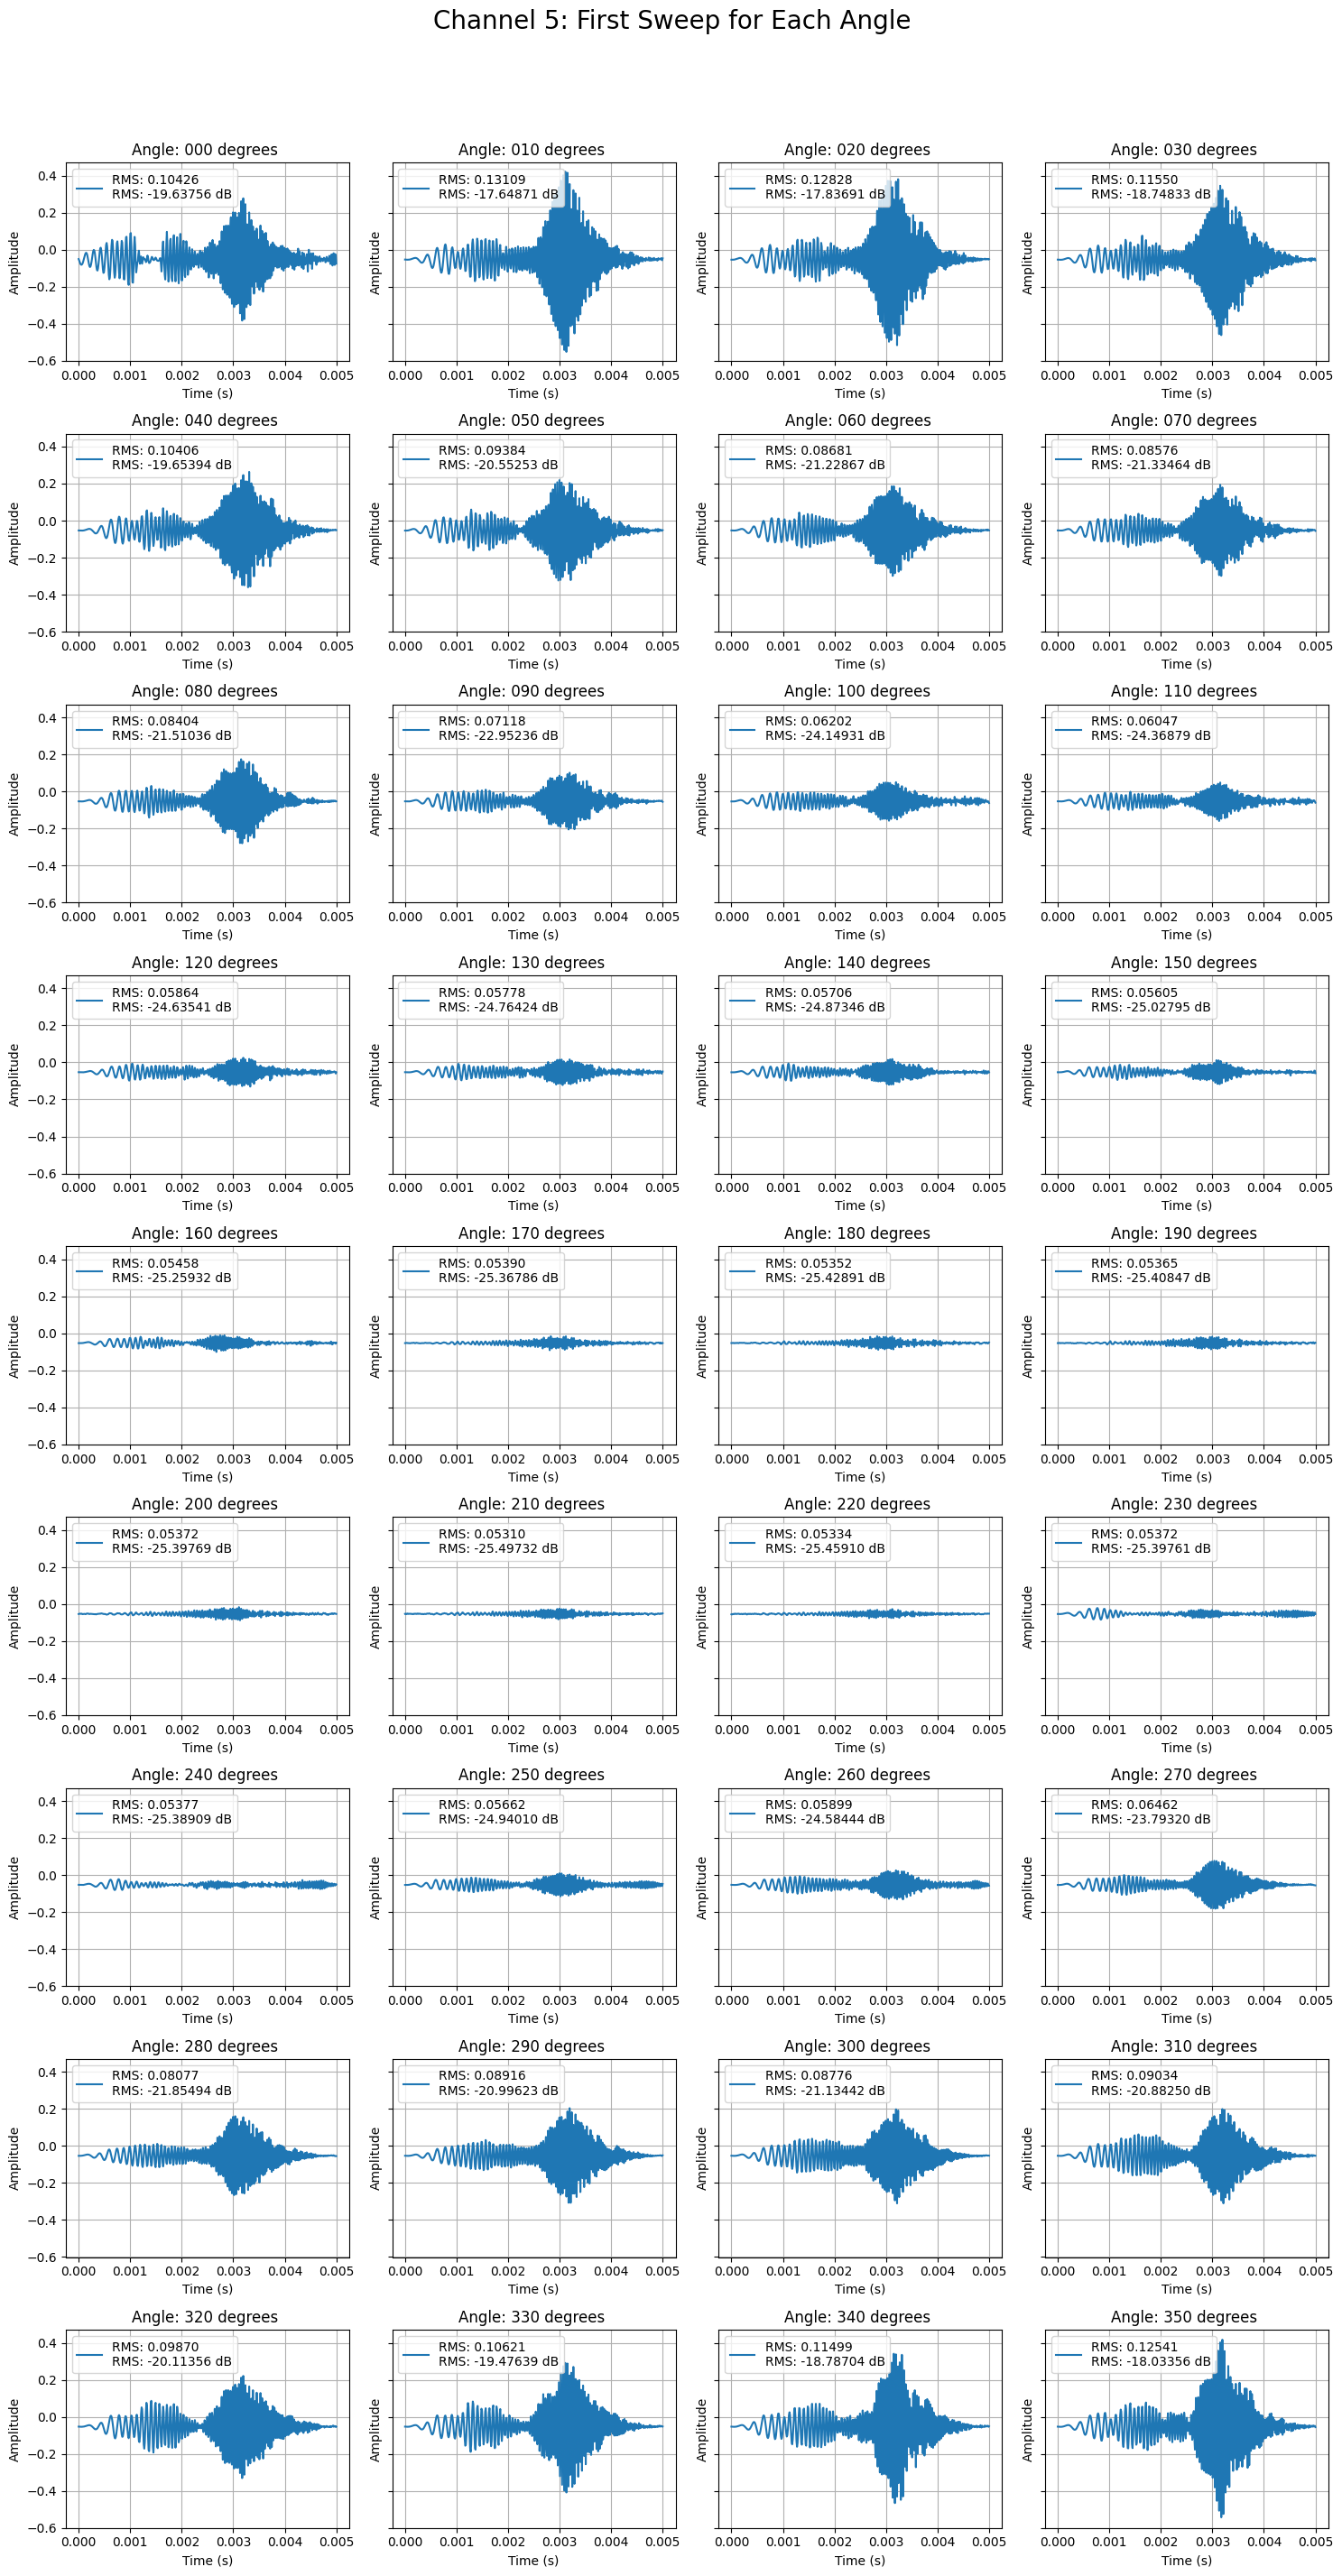

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



RMS Values for All Files:
000_1.wav: 0.09970
010_1.wav: 0.11918
020_1.wav: 0.10611
030_1.wav: 0.09604
040_1.wav: 0.09444
050_1.wav: 0.09816
060_1.wav: 0.08739
070_1.wav: 0.08969
080_1.wav: 0.09067
090_1.wav: 0.06334
100_1.wav: 0.05897
110_1.wav: 0.05593
120_1.wav: 0.05230
130_1.wav: 0.05356
140_1.wav: 0.05277
150_1.wav: 0.05289
160_1.wav: 0.05290
170_1.wav: 0.05313
180_1.wav: 0.05270
190_1.wav: 0.05284
200_1.wav: 0.05458
210_1.wav: 0.05614
220_1.wav: 0.05738
230_1.wav: 0.05735
240_1.wav: 0.05818
250_1.wav: 0.05954
260_1.wav: 0.06132
270_1.wav: 0.07159
280_1.wav: 0.08035
290_1.wav: 0.08550
300_1.wav: 0.09043
310_1.wav: 0.09370
320_1.wav: 0.09162
330_1.wav: 0.10539
340_1.wav: 0.11713
350_1.wav: 0.12126
360_1.wav: 0.09970
000_2.wav: 0.09955
010_2.wav: 0.11670
020_2.wav: 0.11194
030_2.wav: 0.09691
040_2.wav: 0.09660
050_2.wav: 0.09753
060_2.wav: 0.08963
070_2.wav: 0.08925
080_2.wav: 0.09079
090_2.wav: 0.06513
100_2.wav: 0.06112
110_2.wav: 0.05814
120_2.wav: 0.05370
130_2.wav: 0.05468
140_

In [ ]:
# Define the matched filter function
def matched_filter(recording, chirp_template):
    chirp_template = chirp_template[::-1]  # Time-reversed chirp
    filtered_output = signal.fftconvolve(recording, chirp_template, mode='valid')
    return filtered_output

# Detect peaks in the matched filter output
def detect_peaks(filtered_output, threshold=0.8):
    peaks, _ = signal.find_peaks(filtered_output, height=threshold * np.max(filtered_output), distance=(silence_dur/1000+dur)*fs, prominence = 0.5)
    return peaks

# Process each channel
DIR_first_sweep = "./array_calibration/226_238/2025-03-27/extracted_channels/first_sweep/"  # Directory to save the first sweeps

# Dictionary to store RMS values for all files
rms_values_dict = {}

channel_number = 1
for i in range(len(grouped_files)):
    files = grouped_files[i+1]
    print(f"Processing Channel {channel_number}:")
    
    # Create a new figure for each channel
    fig, ax = plt.subplots(figsize=(15, 5))
    ax.set_title(f"Channel {channel_number}")
    ax.set_xlabel("Seconds")
    ax.set_ylabel("Amplitude")
    ax.grid(True)

    for file in files[0:(len(files))]:
        file_path = os.path.join(extracted_channels_dir, file)
        recording, sample_rate = sf.read(file_path)

        # Apply matched filtering
        filtered_output = matched_filter(recording, chirp)

        # Detect peaks
        peaks = detect_peaks(filtered_output)
        print(f"Peaks detected in {file}: {len(peaks)}")
        
        if len(peaks) > 0:
            # Extract the first sweep
            first_sweep_start = peaks[0]
            first_sweep_end = first_sweep_start + len(chirp)
            first_sweep = recording[first_sweep_start:first_sweep_end]

            # Calculate RMS value of the first sweep
            rms_first_sweep = np.sqrt(np.mean(first_sweep**2))
            print(f"RMS value of the first sweep in {file}: {rms_first_sweep:.5f}")

            # Store RMS value in the dictionary
            rms_values_dict[file] = rms_first_sweep

            # Calculate RMS values for all detected peaks
            rms_values = []
            for peak in peaks:
                sweep_start = peak
                sweep_end = sweep_start + len(chirp)
                sweep = recording[sweep_start:sweep_end]
                rms = np.sqrt(np.mean(sweep**2))
                rms_values.append(rms)
                print(f"RMS value of sweep at peak {peak} in {file}: {rms:.5f}")
            
            # Calculate the average RMS value of all peaks
            average_rms = np.mean(rms_values)

            print(f"Average RMS value of all sweeps in {file}: {average_rms:.5f}")

            sf.write(DIR_first_sweep + file, first_sweep, int(fs))
            # Plot the first sweep
            angle_name = file.split('_')[0]
            if int(angle_name):
                ax.plot(np.linspace(0,len(first_sweep),len(first_sweep))/fs, first_sweep, label=f"{angle_name}")
                ax.legend(loc = 'upper right', ncol = 2)
            if len(peaks) < n_sweeps:
                print(f"Only {len(peaks)} sweeps detected in {file} - Channel {channel_number}; expected {n_sweeps}.\n Try adjusting the threshold in detect_peaks.")
                # Plot the filtered output
                # plt.figure(figsize=(15, 5))
                # plt.title(f"Filtered Output - {file}")
                # plt.plot(np.linspace(0, len(filtered_output), len(filtered_output)) / fs, filtered_output, label=f"{file}")
                # plt.plot(peaks / fs, filtered_output[peaks], "x", label="Detected Peaks")
                # plt.xlabel("Seconds")
                # plt.ylabel("Amplitude")
                # plt.grid(True)
                # plt.legend()
        else:
            print(f"No sweeps detected in {file} - Channel {channel_number}")
        

    # Plot all angles, skipping '360'
    fig1, axs = plt.subplots(9, 4, figsize=(15, 30), sharey=True)
    angles = [file.split('_')[0] for file in files]  # Extract angle names from filenames

    idx_to_plot = 0
    for idx, file in enumerate(files):
        if angles[idx] == '360':
            continue  # Skip the 360 angle

        file_path = os.path.join(DIR_first_sweep, file)
        audio, fs = sf.read(file_path)

        rms = np.sqrt(np.mean(audio**2))
        rms_db = 20 * np.log10(rms)
        
        row = idx_to_plot // 4
        col = idx_to_plot % 4
        
        ax = axs[row, col]
        ax.plot(np.linspace(0, len(audio) / fs, len(audio)), audio)
        ax.set_title(f"Angle: {angles[idx]} degrees ")  # Use extracted angle name with units
        ax.set_xlabel("Time (s)")
        ax.set_ylabel("Amplitude")
        ax.grid(True)
        ax.legend([f'RMS: {rms:.5f}\nRMS: {rms_db:.5f} dB'], loc='upper left')

        idx_to_plot += 1

    plt.suptitle(f"Channel {channel_number}: First Sweep for Each Angle", fontsize=20)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to make room for suptitle
    plt.show(block = False)

    ax.legend()
    channel_number += 1

plt.show(block = False)

# Print the dictionary of RMS values
print("\nRMS Values for All Files:")
for file, rms_value in rms_values_dict.items():
    print(f"{file}: {rms_value:.5f}")

4. RMS values of the *whole file* is calculated and displayed in a polar plot

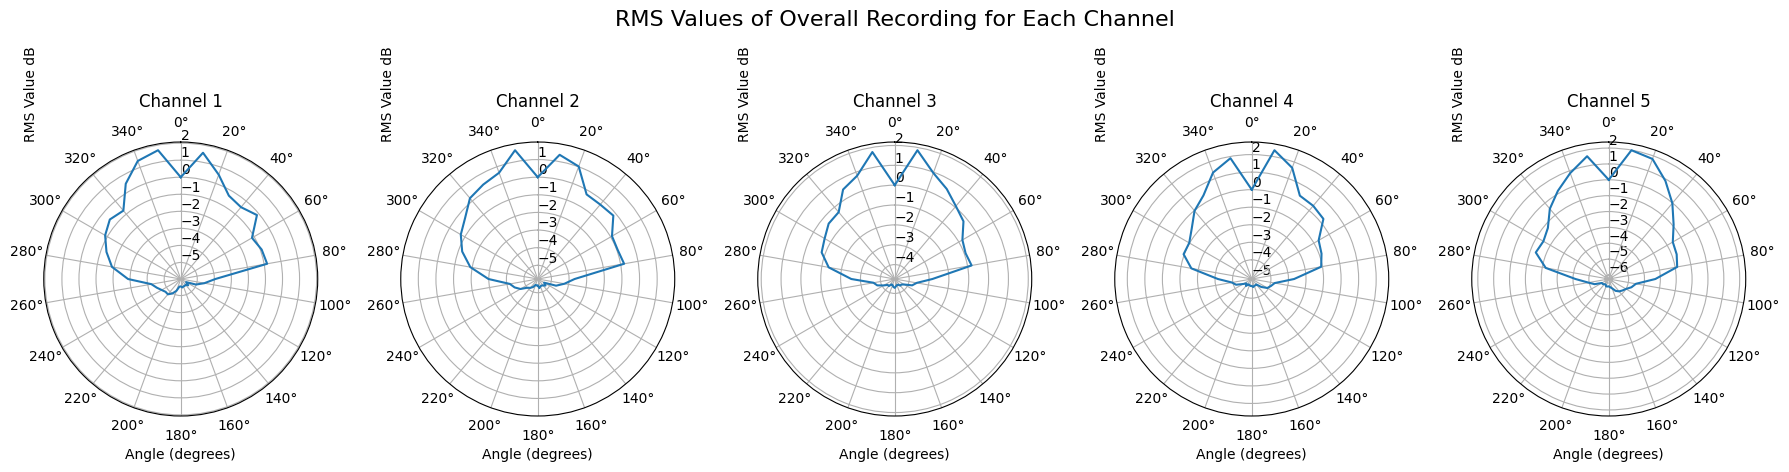

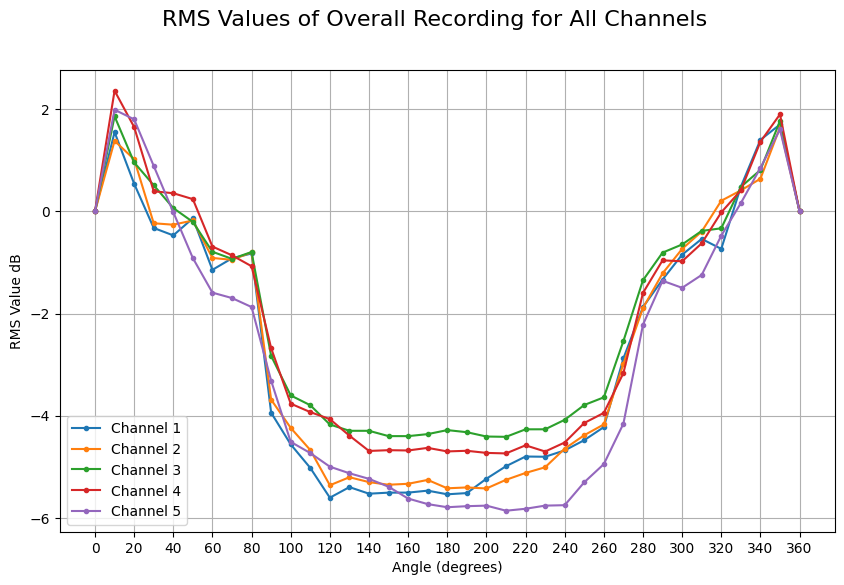

In [11]:
# RMS values of the overall recording for each channel and each angle

num_channels = len(grouped_files)
fig_polar, axs_polar = plt.subplots(1, num_channels, figsize=(18, 5), subplot_kw={'projection': 'polar'})
fig_polar.suptitle("RMS Values of Overall Recording for Each Channel", fontsize=16)

for i in range(num_channels):
    channel_number = i + 1
    files = grouped_files[channel_number]
    
    rms_values = []
    rms_values_norm_db = []
    angles = []
    
    for file in files:
        file_path = os.path.join(extracted_channels_dir, file)
        rms = rms_values_dict[file]
        rms_values.append(rms)

        rms_values_norm = rms_values / rms_values[0]
        rms_values_norm_db = 20 * np.log10(rms_values_norm)

        angle_name = file.split('_')[0]
        angles.append(int(angle_name))
    
    # Convert angles to radians
    angles_rad = np.radians(angles)
    
    # Plot RMS values in polar plot
    ax_polar = axs_polar[i] if num_channels > 1 else axs_polar
    ax_polar.plot(angles_rad, rms_values_norm_db, linestyle='-', label=f"Channel {channel_number}")
    ax_polar.set_title(f"Channel {channel_number}")
    ax_polar.set_theta_zero_location("N")  # Set 0 degrees to North
    ax_polar.set_theta_direction(-1)  # Set clockwise direction
    ax_polar.set_xticks(np.linspace(0, 2 * np.pi, 18, endpoint=False))  # Set angle ticks
    ax_polar.set_xlabel("Angle (degrees)")
    ax_polar.set_ylabel("RMS Value dB", position=(0, 1), ha='left')
    ax_polar.set_rlabel_position(0)

# Linear plot of all channels
fig_linear, ax_linear = plt.subplots(figsize=(10, 6))
fig_linear.suptitle("RMS Values of Overall Recording for All Channels", fontsize=16)

for i in range(num_channels):
    channel_number = i + 1
    files = grouped_files[channel_number]
    
    rms_values = []
    angles = []
    
    for file in files:
        file_path = os.path.join(extracted_channels_dir, file)
        rms = rms_values_dict[file]
        rms_values.append(rms)

        rms_values_norm = rms_values / rms_values[0]
        rms_values_norm_db = 20 * np.log10(rms_values_norm)
        
        angle_name = file.split('_')[0]
        angles.append(int(angle_name))
    
    # Plot RMS values in linear plot
    ax_linear.plot(angles, rms_values_norm_db, marker='.', linestyle='-', label=f"Channel {channel_number}")

ax_linear.set_xlabel("Angle (degrees)")
ax_linear.set_xticks(np.linspace(0, 380, 19, endpoint=False))  # Set angle ticks
ax_linear.set_ylabel("RMS Value dB")
ax_linear.legend()
ax_linear.grid(True)

fig_polar.tight_layout()
plt.show(block = False)


5. Frequncy analysis of every channel up to 40 KHz

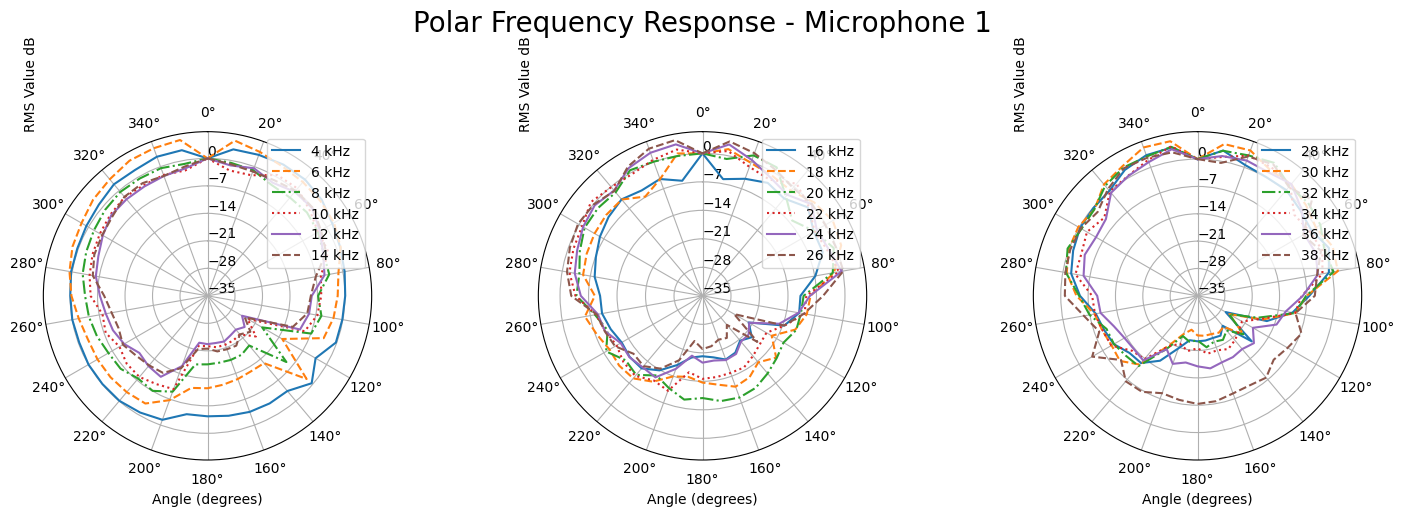

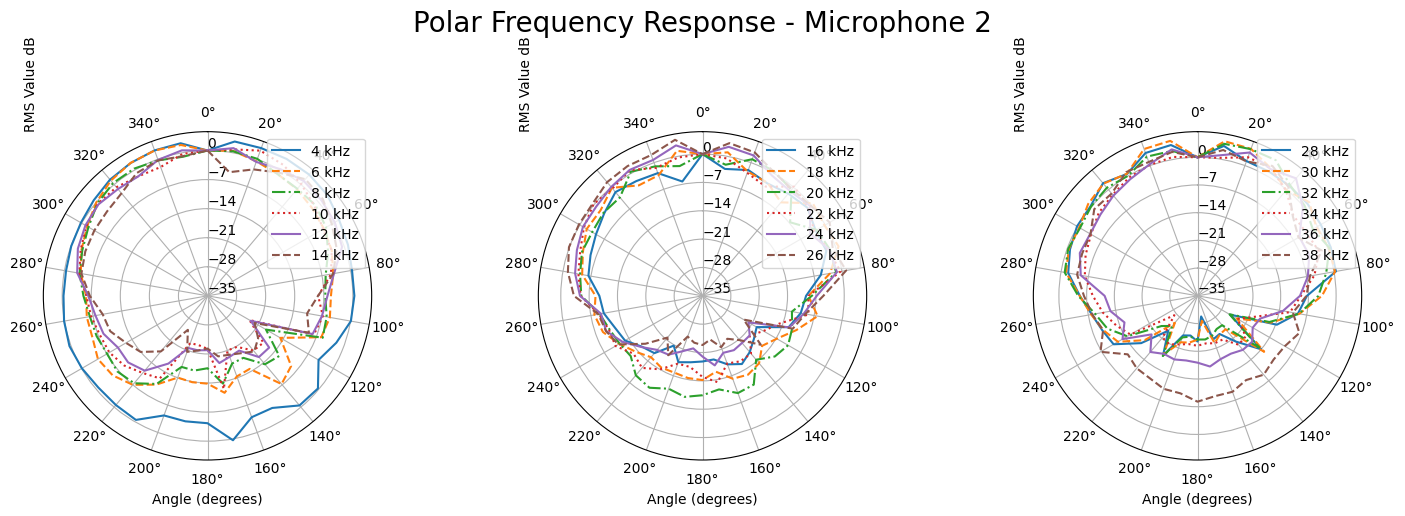

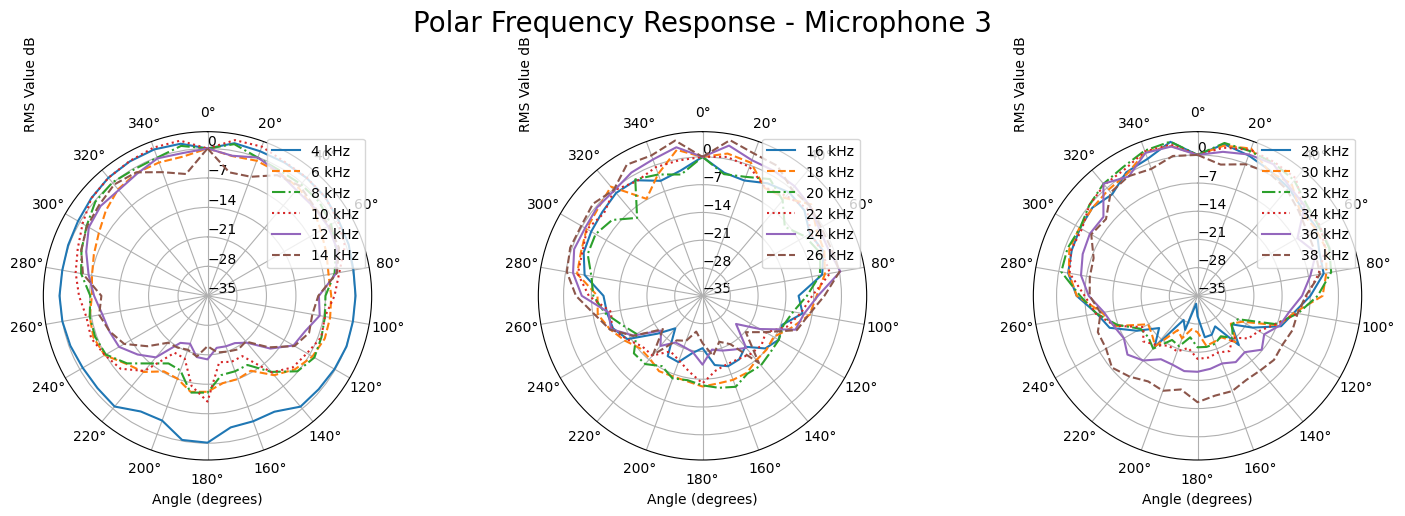

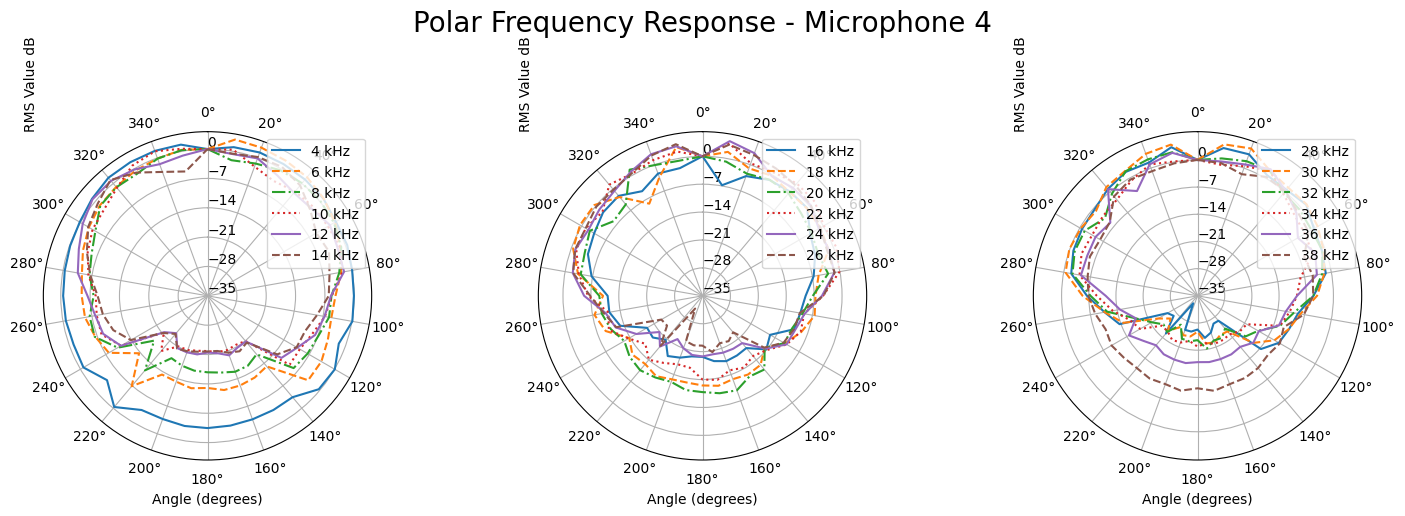

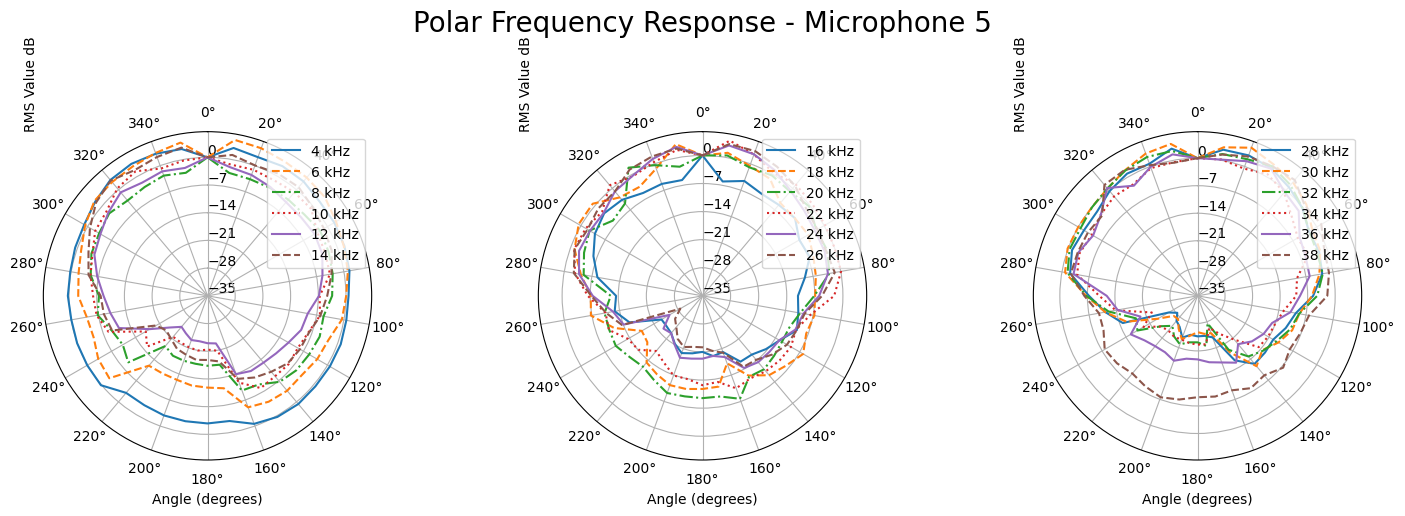

In [ ]:
# import soundfile as sf
# from scipy import fft

# # Central frequencies of the bands
# central_freq = np.array([4e3, 6e3, 8e3, 10e3, 12e3, 14e3, 16e3, 18e3, 20e3, 22e3, 24e3, 26e3, 28e3, 30e3, 32e3, 34e3, 36e3, 38e3])
# BW = 1e3  # Bandwidth of the bands
# linestyles = ["-", "--", "-.", ":", "-", "--"]  # Line styles for the plot

# # Group central frequencies into 3 sets of 6 bands each
# num_bands_per_plot = 6
# central_freq_sets = [central_freq[i * num_bands_per_plot:(i + 1) * num_bands_per_plot] for i in range(3)]

# # Number of microphones
# num_mics = num_channels

# # Plot for each microphone
# for mic in range(1, num_mics + 1):
#     files = grouped_files[mic]
#     angles = [int(file.split('_')[0]) for file in files]  # Extract angles from filenames

#     # Create a figure with 3 polar subplots
#     fig, axes = plt.subplots(1, 3, subplot_kw={"projection": "polar"}, figsize=(15, 5))
#     plt.suptitle(f"Polar Frequency Response - Microphone {mic}", fontsize=20)

#     for ax_idx, ax in enumerate(axes):
#         ii = 0
#         for fc in central_freq_sets[ax_idx]:
            
#             audio_patt = []

#             for file in files:
#                 file_path = os.path.join(DIR_first_sweep, file)
#                 audio, fs = sf.read(file_path)

#                 # Compute FFT
#                 audio_freq = fft.fft(audio, n=2048)
#                 audio_freq = audio_freq[:1024]
#                 freqs = fft.fftfreq(2048, 1 / fs)[:1024]

#                 # Compute mean radiance in the band
#                 band_mean = np.mean(np.abs(audio_freq[(freqs > fc - BW) & (freqs < fc + BW)]))
#                 audio_patt.append(band_mean)

#             # Normalize and plot
#             audio_patt_norm = audio_patt / audio_patt[0] # Normalize the radiance
#             audio_patt_norm_dB = 20 * np.log10(audio_patt_norm) # Convert the radiance to dB
            
#             if fc >= 10e3:
#                 label = f"{fc / 1e3:.0f} kHz"
#             else:
#                 label = f"{fc / 1e3:.0f} kHz"
            
#             ax.plot(np.deg2rad(angles), audio_patt_norm_dB, label=label, linestyle=linestyles[ii])
#             ii +=1
#         # Configure polar plot
#         ax.legend(loc="upper right")
#         ax.set_theta_offset(np.pi / 2)
#         ax.set_theta_zero_location("N")  # Set 0 degrees to North
#         ax.set_theta_direction(-1)  # Set clockwise direction
#         ax.set_xticks(np.linspace(0, 2 * np.pi, 18, endpoint=False))  # Set angle ticks
#         ax.set_yticks(np.linspace(-35, 0, 6))
#         ax.set_xlabel("Angle (degrees)")
#         ax.set_ylabel("RMS Value dB", position=(0, 1), ha='left')
#         ax.set_rlabel_position(0)


#     plt.tight_layout()

#     plt.show()

# Final notes

- 3 mics have a negative bias around -0.053, mic 3 at -0.065 and mic 4 at -0.060. 
- There is a different zero bias across microphones, but the diffence is pretty low (approximately 10% of the first sweep amplitude)
- frequency analysis shows a clear pattern connected to the microphopne position along the array: mic1 (on the left of the robot) has a bias to pick up more on its left side across all frequncies.   Similarly for mic5 (last on the right) accordingly.
